# Double Cartpole



The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta_1 & \dot{\theta_1} & \theta_2 & \dot{\theta_2}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the carptole upright:
$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0 & 0 & 0
    \end{bmatrix}
\end{equation*}
$$

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pddp
import pddp.examples

In [5]:
import torch
import numpy as np

In [6]:
DT = 0.05  # Time step (s).
RENDER = True  # Whether to render the environment or not.
N = 50 # Horizon length.

# Disable uncertainty since we are dealing with known dynamics.
ENCODING = pddp.StateEncoding.IGNORE_UNCERTAINTY

In [7]:
cost = pddp.examples.double_cartpole.DoubleCartpoleCost()
model = pddp.examples.double_cartpole.DoubleCartpoleDynamicsModel(DT)
env = pddp.examples.double_cartpole.DoubleCartpoleEnv(dt=DT, render=RENDER)

In [8]:
def plot(Z, U):
    t = np.arange(N + 1) * DT
    X = pddp.utils.encoding.decode_mean(Z, ENCODING).detach().numpy()
    U = U.detach().numpy()

    x = X[:, 0]
    x_dot = X[:, 1]
    theta1 = np.unwrap(X[:, 2])  # Makes for smoother plots.
    theta1_dot = X[:, 3]
    theta2 = np.unwrap(X[:, 4])  # Makes for smoother plots.
    theta2_dot = X[:, 5]
    
    plt.figure()
    plt.plot(theta1, theta1_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Link 1 Orientation Phase Plot")

    plt.figure()
    plt.plot(theta2, theta2_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Link 2 Orientation Phase Plot")
    
    plt.figure()
    plt.plot(t, x)
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("Position path")
    
    plt.figure()
    plt.plot(t, x_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m / s)")
    plt.title("Velocity path")
    
    plt.figure()
    plt.plot(t, theta1)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Link 1 orientation path")

    plt.figure()
    plt.plot(t, theta1_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Link 1 angular velocity path")
    
    plt.figure()
    plt.plot(t, theta2)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Link 2 orientation path")
    
    plt.figure()
    plt.plot(t, theta2_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Link 2 angular velocity path")

    plt.figure()
    plt.plot(t[:-1], U)
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.title("Action path")
    
    plt.figure()
    plt.plot(J_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Total loss")
    plt.title("Loss path")

In [9]:
def on_iteration(iteration, Z, U, J_opt, accepted, converged):
    J_opt = J_opt.detach().numpy()

    J_hist.append(J_opt)
    info = "CONVERGED" if converged else ("accepted" if accepted else "FAILED")
    final_state = Z[-1].detach().numpy()
    final_state[2] = (final_state[2] + np.pi) % (2 * np.pi) - np.pi
    final_state[4] = (final_state[4] + np.pi) % (2 * np.pi) - np.pi
    print("iteration", iteration + 1, info, J_opt, final_state)

In [10]:
controller = pddp.controllers.iLQRController(env, model, cost)

In [11]:
U = 1e-1 * torch.randn(N, model.action_size)

In [12]:
J_hist = []
controller.eval()
Z, U = controller.fit(U, encoding=ENCODING, n_iterations=200, tol=0,
                      on_iteration=on_iteration)

iteration 7 accepted 1088.3684 [-0.01558929 -0.03402154 -3.1280112   0.03765006 -3.132039    0.03099311]
iteration 8 accepted 1088.014 [-0.00396071 -0.01375412 -3.1279457   0.00831299 -3.1287491   0.00643703]
iteration 9 accepted 1086.4275 [ 3.5996654e-03 -1.0651030e-02 -3.1053185e+00 -2.8620688e-03
 -3.0225120e+00  5.5319965e-03]
iteration 12 accepted 1063.9685 [ 0.00975653 -0.0278182  -3.0320308  -0.06322008 -2.6147213   0.2084533 ]
iteration 14 accepted 1029.2346 [ 0.00388662 -0.04374566 -2.9487832  -0.07045101 -2.2375562   0.46863008]
iteration 15 FAILED 1029.2346 [ 0.00388662 -0.04374566 -2.9487832  -0.07045101 -2.2375562   0.46863008]
iteration 16 accepted 976.7798 [-0.02441035 -0.07318381 -2.802882    0.06781325 -1.7676405   0.79186845]
iteration 17 accepted 914.9419 [-0.05306514 -0.10733122 -2.63079     0.18636948 -1.4451555   0.87188494]
iteration 19 accepted 841.9584 [-0.07938066 -0.03835079 -2.0394022   0.9677791  -0.9279211   0.95883334]
iteration 20 FAILED 841.9584 [-0.079

iteration 93 FAILED 291.50174 [ 0.01776482  0.00045639 -0.2815011   0.07890773  0.01497048  0.00242442]
iteration 94 FAILED 291.50174 [ 0.01776482  0.00045639 -0.2815011   0.07890773  0.01497048  0.00242442]
iteration 95 accepted 290.95667 [ 0.02179801  0.00701559 -0.270387    0.07469714  0.01244753  0.0059129 ]
iteration 96 accepted 290.41696 [ 0.02760063  0.00906998 -0.25860196  0.07247841  0.00880783  0.00927395]
iteration 97 accepted 289.91034 [ 0.03561804  0.00723082 -0.24812871  0.07211864  0.0049135   0.0128004 ]
iteration 98 accepted 288.89056 [ 0.03066142  0.00612819 -0.25440532  0.07242024  0.01931065  0.00813675]
iteration 99 accepted 288.13223 [-0.00309415  0.01232046 -0.29786664  0.08689547  0.04985779 -0.01323223]
iteration 100 accepted 287.95255 [-0.00363814  0.01370335 -0.2969125   0.0856179   0.05066603 -0.01397854]
iteration 101 accepted 287.854 [-0.00392156  0.0153715  -0.29540807  0.08371902  0.05080765 -0.01466423]
iteration 102 accepted 287.40915 [-0.00709733  0.0

/Users/anass/Dev/personal/pddp/pddp/controllers/ilqr.py:235: UserWarning: exceeded max regularization term
  warnings.warn("exceeded max regularization term")


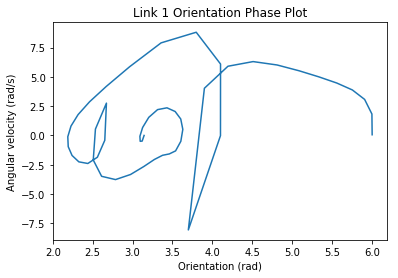

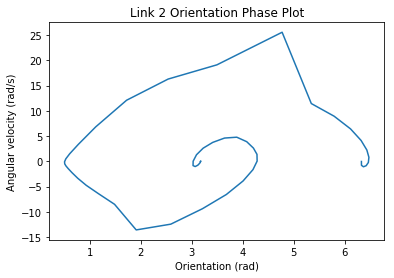

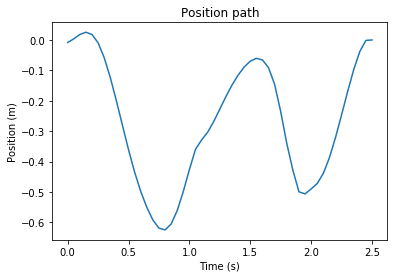

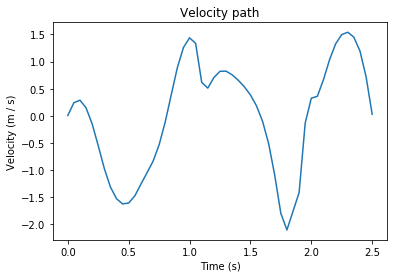

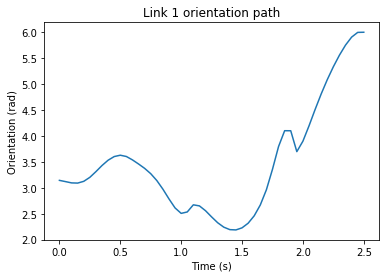

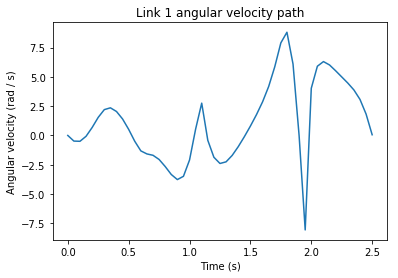

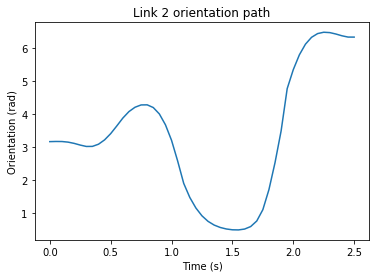

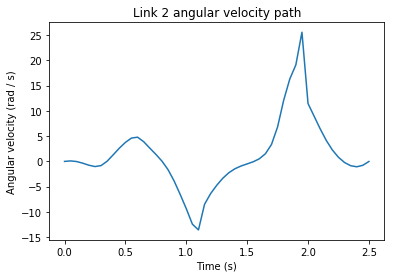

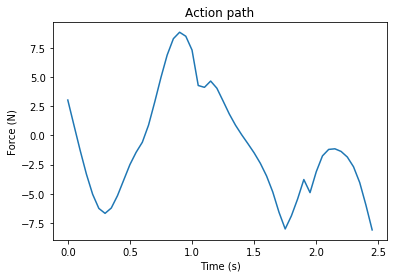

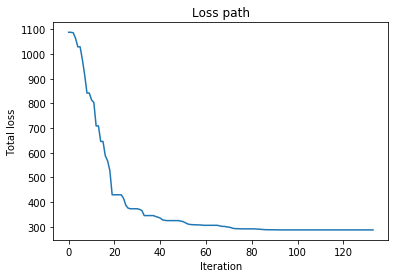

In [13]:
plot(Z, U)

In [14]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


In [15]:
env.reset()
for i in range(N):
    z = env.get_state().encode(ENCODING)
    u = controller(z, i, ENCODING)
    env.apply(u)

In [16]:
env.close()